### introduction

I was trying to figure out how to use imu, but it was more difficult than I imagined and did not lead to an improvement in my score.

I implemented an extended Kalman filter using imu, and I hope this will be helpful.

Originally, I wanted to use angular velocity and acceleration, but I could not align the axes for acceleration, so I only used angular velocity in the y-direction.
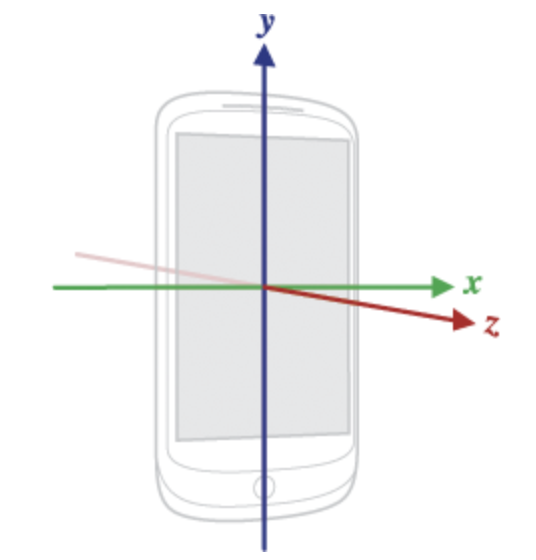

imuの活用方法を考えていましたが，想像以上に難しくスコアの改善に繋がりませんでした．

imuを用いて拡張カルマンフィルタを実装したので，参考になれば幸いです．

本来は角速度と加速度を使いたかったのですが，加速度に関して軸合わせが出来ていないため，y方向の角速度を使うのみとなっています．

In [1]:
!pip install simdkalman
!pip install pymap3d

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 625.8 kB/s eta 0:00:00


In [2]:
import pykalman
import simdkalman
from tqdm.notebook import tqdm
from dataclasses import dataclass
from scipy.interpolate import InterpolatedUnivariateSpline
import glob
from joblib import Parallel, delayed
import random
from functools import partial
import numpy as np
import pandas as pd
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import savgol_filter
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings('ignore')
from pykalman import KalmanFilter,AdditiveUnscentedKalmanFilter,UnscentedKalmanFilter
import pymap3d as pm
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import distance
INPUT_PATH = '../input/smartphone-decimeter-2022'

WGS84_SEMI_MAJOR_AXIS = 6378137.0
WGS84_SEMI_MINOR_AXIS = 6356752.314245
WGS84_SQUARED_FIRST_ECCENTRICITY  = 6.69437999013e-3
WGS84_SQUARED_SECOND_ECCENTRICITY = 6.73949674226e-3

HAVERSINE_RADIUS = 6_371_000

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.simplefilter('ignore')
import pymap3d.vincenty as pmv

In [3]:
def visualize_trafic(df,col, name_="velocity",zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="LatitudeDegrees",
                            lon="LongitudeDegrees",
                            
                            #Here, plotly detects color of series
                            color=name_,
                            labels=name_,
                            hover_data = col ,
                            zoom=zoom,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()

In [4]:
base_path = "../input/smartphone-decimeter-2022/train/"
tripId = "2020-05-15-US-MTV-1/GooglePixel4XL"
df_train = pd.read_csv("../input/gsdc2-baseline-sub/baseline_train.csv")
df_train = df_train[df_train.tripId == tripId]
df_train.head(3)

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees,higth,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters
0,2020-05-15-US-MTV-1/GooglePixel4XL,1589573679445,37.416664,-122.082013,-31.511228,-2.693907e+06,-4.297452e+06,3.854203e+06
1,2020-05-15-US-MTV-1/GooglePixel4XL,1589573680445,37.416576,-122.082059,-32.738374,-2.693913e+06,-4.297455e+06,3.854195e+06
2,2020-05-15-US-MTV-1/GooglePixel4XL,1589573681445,37.416519,-122.082083,-36.673391,-2.693915e+06,-4.297454e+06,3.854187e+06


### Merge imu data  
note:Magnetic sensors are not used due to their high noise

In [5]:
imu = pd.read_csv(base_path + tripId +"/device_imu.csv")
acc = imu.query(f"MessageType=='UncalAccel'").reset_index(drop = True)
gyr = imu.query(f"MessageType=='UncalGyro'").reset_index(drop = True)
mag = imu.query(f"MessageType=='UncalMag'").reset_index(drop = True)

In [6]:
df_temp = pd.merge_asof(
    df_train.sort_values('UnixTimeMillis'), 
    acc.sort_values('utcTimeMillis'), 
    left_on=['UnixTimeMillis'], 
    right_on=['utcTimeMillis'], 
    direction='nearest',
    suffixes = ("","_acc"), 
    tolerance=1000
    )
display(df_temp.head(3))
df_temp.isnull().sum()

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees,higth,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters,MessageType,utcTimeMillis,MeasurementX,MeasurementY,MeasurementZ,BiasX,BiasY,BiasZ
0,2020-05-15-US-MTV-1/GooglePixel4XL,1589573679445,37.416664,-122.082013,-31.511228,-2.693907e+06,-4.297452e+06,3.854203e+06,UncalAccel,1589573679447,0.237913,9.250001,1.784782,0.0,0.0,0.0
1,2020-05-15-US-MTV-1/GooglePixel4XL,1589573680445,37.416576,-122.082059,-32.738374,-2.693913e+06,-4.297455e+06,3.854195e+06,UncalAccel,1589573680451,-0.004363,10.069017,0.605405,0.0,0.0,0.0
2,2020-05-15-US-MTV-1/GooglePixel4XL,1589573681445,37.416519,-122.082083,-36.673391,-2.693915e+06,-4.297454e+06,3.854187e+06,UncalAccel,1589573681445,-0.123075,9.664932,0.985953,0.0,0.0,0.0


tripId                    0
UnixTimeMillis            0
LatitudeDegrees           0
LongitudeDegrees          0
higth                     0
WlsPositionXEcefMeters    0
WlsPositionYEcefMeters    0
WlsPositionZEcefMeters    0
MessageType               0
utcTimeMillis             0
MeasurementX              0
MeasurementY              0
MeasurementZ              0
BiasX                     0
BiasY                     0
BiasZ                     0
dtype: int64

In [7]:
df_temp = pd.merge_asof(
    df_temp.sort_values('UnixTimeMillis'), 
    gyr.sort_values('utcTimeMillis'), 
    left_on=['UnixTimeMillis'], 
    right_on=['utcTimeMillis'], 
    direction='nearest',
    suffixes = ("","_gyr"), 
    tolerance=1000)
display(df_temp.head(3))
df_temp.isnull().sum()

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees,higth,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters,MessageType,utcTimeMillis,MeasurementX,MeasurementY,MeasurementZ,BiasX,BiasY,BiasZ,MessageType_gyr,utcTimeMillis_gyr,MeasurementX_gyr,MeasurementY_gyr,MeasurementZ_gyr,BiasX_gyr,BiasY_gyr,BiasZ_gyr
0,2020-05-15-US-MTV-1/GooglePixel4XL,1589573679445,37.416664,-122.082013,-31.511228,-2.693907e+06,-4.297452e+06,3.854203e+06,UncalAccel,1589573679447,0.237913,9.250001,1.784782,0.0,0.0,0.0,UncalGyro,1589573679450,-0.022198,0.004974,0.014298,0.0,0.0,0.0
1,2020-05-15-US-MTV-1/GooglePixel4XL,1589573680445,37.416576,-122.082059,-32.738374,-2.693913e+06,-4.297455e+06,3.854195e+06,UncalAccel,1589573680451,-0.004363,10.069017,0.605405,0.0,0.0,0.0,UncalGyro,1589573680437,0.020855,-0.012030,0.010086,0.0,0.0,0.0
2,2020-05-15-US-MTV-1/GooglePixel4XL,1589573681445,37.416519,-122.082083,-36.673391,-2.693915e+06,-4.297454e+06,3.854187e+06,UncalAccel,1589573681445,-0.123075,9.664932,0.985953,0.0,0.0,0.0,UncalGyro,1589573681450,0.004462,0.002903,-0.012339,0.0,0.0,0.0


tripId                    0
UnixTimeMillis            0
LatitudeDegrees           0
LongitudeDegrees          0
higth                     0
WlsPositionXEcefMeters    0
WlsPositionYEcefMeters    0
WlsPositionZEcefMeters    0
MessageType               0
utcTimeMillis             0
MeasurementX              0
MeasurementY              0
MeasurementZ              0
BiasX                     0
BiasY                     0
BiasZ                     0
MessageType_gyr           0
utcTimeMillis_gyr         0
MeasurementX_gyr          0
MeasurementY_gyr          0
MeasurementZ_gyr          0
BiasX_gyr                 0
BiasY_gyr                 0
BiasZ_gyr                 0
dtype: int64

In [8]:
# Calibrate gravity

In [9]:
df_temp.head(2)

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees,higth,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters,MessageType,utcTimeMillis,MeasurementX,MeasurementY,MeasurementZ,BiasX,BiasY,BiasZ,MessageType_gyr,utcTimeMillis_gyr,MeasurementX_gyr,MeasurementY_gyr,MeasurementZ_gyr,BiasX_gyr,BiasY_gyr,BiasZ_gyr
0,2020-05-15-US-MTV-1/GooglePixel4XL,1589573679445,37.416664,-122.082013,-31.511228,-2.693907e+06,-4.297452e+06,3.854203e+06,UncalAccel,1589573679447,0.237913,9.250001,1.784782,0.0,0.0,0.0,UncalGyro,1589573679450,-0.022198,0.004974,0.014298,0.0,0.0,0.0
1,2020-05-15-US-MTV-1/GooglePixel4XL,1589573680445,37.416576,-122.082059,-32.738374,-2.693913e+06,-4.297455e+06,3.854195e+06,UncalAccel,1589573680451,-0.004363,10.069017,0.605405,0.0,0.0,0.0,UncalGyro,1589573680437,0.020855,-0.012030,0.010086,0.0,0.0,0.0


In [10]:
#with a stop state up to 100
def rotation_R(df):
    mean_ = df[:100].mean()
    ax = - mean_.MeasurementZ
    ay = - mean_.MeasurementX
    az =   mean_.MeasurementY
    roll = (np.arctan2(ay,az))
    pitch = (-np.arctan2(ax,np.sqrt(ay ** 2 + az ** 2)))
    yaw = 0
    c_roll = np.array([[1,             0,             0], 
                       [0,  np.cos(roll), -np.sin(roll)],
                       [0,  np.sin(roll),  np.cos(roll)]
                      ])

    c_pitch = np.array([[ np.cos(pitch), 0,  np.sin(pitch)], 
                        [ 0,             1,              0],
                        [-np.sin(pitch), 0,  np.cos(pitch)]
                       ])

    c_yaw = np.array([[ np.cos(yaw),-np.sin(yaw),      0], 
                      [ np.sin(yaw), np.cos(yaw),      0],
                      [ 0,             0,              1]
                     ])
    R = c_yaw @ c_pitch @ c_roll
    return R

def calib(df_temp,R):
    df_temp[["MeasurementZ_gyr_"]] = - df_temp[["MeasurementZ_gyr"]]
    df_temp[["MeasurementX_gyr_"]] = - df_temp[["MeasurementX_gyr"]]
    w_data = df_temp[["MeasurementZ_gyr_","MeasurementX_gyr_","MeasurementY_gyr"]].to_numpy()
    
    df_temp[["MeasurementZ_"]] = - df_temp[["MeasurementZ"]]
    df_temp[["MeasurementX_"]] = - df_temp[["MeasurementX"]]
    acc_data = df_temp[["MeasurementZ_","MeasurementX_","MeasurementY"]].to_numpy()

    acc_data_ = acc_data.copy()
    for i in range(len(w_data)):
        acc_data_[i] = R @ acc_data[i]
    
    w_data_ = w_data.copy()
    for i in range(len(w_data)):
        w_data_[i] = R @ w_data[i]
    
    df_temp[["acc_x","acc_y","acc_z"]] = acc_data_
    df_temp[["w_x","w_y","w_z"]] = w_data_
    
    return df_temp

 
R = rotation_R(df_temp)
df_temp = calib(df_temp,R)
df_temp.head()

,tripId,UnixTimeMillis,LatitudeDegrees,LongitudeDegrees,higth,WlsPositionXEcefMeters,WlsPositionYEcefMeters,WlsPositionZEcefMeters,MessageType,utcTimeMillis,MeasurementX,MeasurementY,MeasurementZ,BiasX,BiasY,BiasZ,MessageType_gyr,utcTimeMillis_gyr,MeasurementX_gyr,MeasurementY_gyr,MeasurementZ_gyr,BiasX_gyr,BiasY_gyr,BiasZ_gyr,MeasurementZ_gyr_,MeasurementX_gyr_,MeasurementZ_,MeasurementX_,acc_x,acc_y,acc_z,w_x,w_y,w_z
0,2020-05-15-US-MTV-1/GooglePixel4XL,1589573679445,37.416664,-122.082013,-31.511228,-2.693907e+06,-4.297452e+06,3.854203e+06,UncalAccel,1589573679447,0.237913,9.250001,1.784782,0.0,0.0,0.0,UncalGyro,1589573679450,-0.022198,0.004974,0.014298,0.0,0.0,0.0,-0.014298,0.022198,-1.784782,-0.237913,-0.840451,-0.323677,9.380482,-0.013700,0.022151,0.006599
1,2020-05-15-US-MTV-1/GooglePixel4XL,1589573680445,37.416576,-122.082059,-32.738374,-2.693913e+06,-4.297455e+06,3.854195e+06,UncalAccel,1589573680451,-0.004363,10.069017,0.605405,0.0,0.0,0.0,UncalGyro,1589573680437,0.020855,-0.012030,0.010086,0.0,0.0,0.0,-0.010086,-0.020855,-0.605405,0.004363,0.415930,-0.089005,10.078230,-0.011271,-0.020743,-0.011140
2,2020-05-15-US-MTV-1/GooglePixel4XL,1589573681445,37.416519,-122.082083,-36.673391,-2.693915e+06,-4.297454e+06,3.854187e+06,UncalAccel,1589573681445,-0.123075,9.664932,0.985953,0.0,0.0,0.0,UncalGyro,1589573681450,0.004462,0.002903,-0.012339,0.0,0.0,0.0,0.012339,-0.004462,-0.985953,0.123075,-0.003419,0.033448,9.715813,0.012565,-0.004489,0.001599
3,2020-05-15-US-MTV-1/GooglePixel4XL,1589573682445,37.416542,-122.082077,-37.085489,-2.693914e+06,-4.297453e+06,3.854189e+06,UncalAccel,1589573682450,-0.106515,9.743280,0.989118,0.0,0.0,0.0,UncalGyro,1589573682453,0.005325,0.000134,-0.008487,0.0,0.0,0.0,0.008487,-0.005325,-0.989118,0.106515,0.001339,0.016162,9.793924,0.008452,-0.005326,-0.000775
4,2020-05-15-US-MTV-1/GooglePixel4XL,1589573683445,37.416538,-122.082078,-32.337190,-2.693916e+06,-4.297456e+06,3.854191e+06,UncalAccel,1589573683451,-0.102974,9.607479,1.157913,0.0,0.0,0.0,UncalGyro,1589573683440,-0.004751,0.000016,-0.008731,0.0,0.0,0.0,0.008731,0.004751,-1.157913,0.102974,-0.180326,0.013880,9.675862,0.008692,0.004751,-0.000823


<AxesSubplot:>

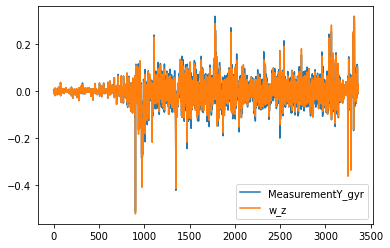

In [11]:
df_temp[["MeasurementY_gyr","w_z"]].plot()

<AxesSubplot:>

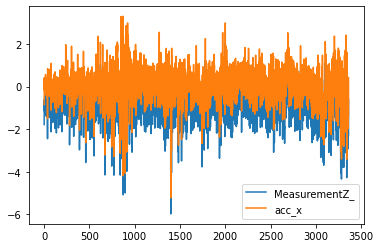

In [12]:
df_temp[["MeasurementZ_","acc_x"]].plot()

In [13]:
"""
x -> roll
y -> pitch
z -> yaw
"""

'\nx -> roll\ny -> pitch\nz -> yaw\n'

In [14]:
#https://www.kaggle.com/code/junkoda/wls-velocity-estimation-from-doppler-shift

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import glob
import scipy.optimize
from tqdm.auto import tqdm

c = 299_792_458  # speed of light in vaccum [m/s]
omega = 7.292115e-5  # angular velocity [rad/s] in ECEF coordinate WGS 84

In [16]:
base_path

'../input/smartphone-decimeter-2022/train/'

In [17]:
gnss = pd.read_csv(f'{base_path}{tripId}/device_gnss.csv', dtype={'SignalType': str})
truth = pd.read_csv(f'{base_path}{tripId}/ground_truth.csv')

In [18]:
m = len(truth)  # Number of timesteps
y_wls = np.zeros((m, 3))  # Receiver positions estimated here
v_wls = np.zeros((m, 3))  # Receiver velocities estimated in ECEF frame

for i, (t_nano, df1) in enumerate(tqdm(gnss.groupby('TimeNanos'), total=m)):
    #
    # 1. Position estimation
    #
    
    # Corrected pseudo range ρ [m]
    rho = (df1['RawPseudorangeMeters'] + df1['SvClockBiasMeters'] - df1['IsrbMeters']
           - df1['IonosphericDelayMeters'] - df1['TroposphericDelayMeters']).values

    # Satellite positions at emmision time t_i in ECEF(t_i)
    x_sat = df1[['SvPositionXEcefMeters', 'SvPositionYEcefMeters', 'SvPositionZEcefMeters']].values

    # Inverse uncertainty weight
    w = 1 / df1['RawPseudorangeUncertaintyMeters'].values

    def f(y):
        """
        Compute error for trial receiver position y

        y (y1, y2, y3, b):
          y: recerver position at receiving time
          b: receiver clock bias in meters
        """
        b = y[3]
        r = rho - b  # distance to each satellite [m]
        tau = r / c  # signal flight time

        # Rotate satellite positions at emission to present ECEF coordinate
        x = np.empty_like(x_sat)
        cosO = np.cos(omega * tau)
        sinO = np.sin(omega * tau)
        x[:, 0] =  cosO * x_sat[:, 0] + sinO * x_sat[:, 1]
        x[:, 1] = -sinO * x_sat[:, 0] + cosO * x_sat[:, 1]
        x[:, 2] = x_sat[:, 2]

        return w * (np.sqrt(np.sum((x - y[:3])**2, axis=1)) - r)

    
    # Fit receiver position y and clock bias b
    x0 = np.zeros(4)  # initial guess
    opt = scipy.optimize.least_squares(f, x0)
    y = opt.x[:3]
    b = opt.x[3]
    
    #
    # 2. Velocity estimation
    #
    
    # Use estimated position
    r = rho - b  # distance to each satellite [m]
    tau = r / c
    
    # Satellite positions at emission in present (signal arrival time) ECEF coordinate
    x = np.empty_like(x_sat)
    cosO = np.cos(omega * tau)
    sinO = np.sin(omega * tau)
    x[:, 0] =  cosO * x_sat[:, 0] + sinO * x_sat[:, 1]
    x[:, 1] = -sinO * x_sat[:, 0] + cosO * x_sat[:, 1]
    x[:, 2] = x_sat[:, 2]

    v_sat_ecef = df1[['SvVelocityXEcefMetersPerSecond',
                      'SvVelocityYEcefMetersPerSecond',
                      'SvVelocityZEcefMetersPerSecond']].values
        
    # Velocity in inertial frame (matching ECEF at signal emission time)
    v_sate = np.empty_like(v_sat_ecef)
    v_sate[:, 0] = v_sat_ecef[:, 0] - omega * x_sat[:, 1]
    v_sate[:, 1] = v_sat_ecef[:, 1] + omega * x_sat[:, 0]
    v_sate[:, 2] = v_sat_ecef[:, 2]

    # Rotate the velocity to another inertial frame matching ECEF at signal arrival time
    v_sat = np.empty_like(v_sat_ecef)
    v_sat[:, 0] =  cosO * v_sate[:, 0] + sinO * v_sate[:, 1]
    v_sat[:, 1] = -sinO * v_sate[:, 0] + cosO * v_sate[:, 1]
    v_sat[:, 2] = v_sate[:, 2]

    # Direction from receiver to sattelites
    r_vec = x - y.reshape(1, 3)
    r_hat = r_vec / np.linalg.norm(r_vec, axis=1).reshape(-1, 1)  # unit vector
    
    # Line-of-sight velocity from doppler shift data
    v_los = df1['PseudorangeRateMetersPerSecond'].values  

    # Inverse uncertainty in v_los for weights
    w_vel = 1 / df1['PseudorangeRateUncertaintyMetersPerSecond'].values
    
    def f_vel(v):
        """
        Return weighted error for velocity estimate v

        v (v1, v2, v3, v_b): Receiver velocity and velocity bias
        """    
        # Line-of-sight relative velocity for fitting parameter v
        v_rel = np.sum((v_sat - v[:3].reshape(1, 3)) * r_hat, axis=1)  # dot product to r_hat

        err = w_vel * (v_rel - v_los + v[3])

        return err
    
    v0 = np.zeros(4)  # initial guess
    opt = scipy.optimize.least_squares(f_vel, v0)
    v = opt.x[:3]
    vb = opt.x[3]
    
    # Receiver velocity in ECEF frame
    v_ecef = np.zeros(3)
    v_ecef[0] = v[0] + omega * y[1]
    v_ecef[1] = v[1] - omega * y[0]
    v_ecef[2] = v[2]

    # Save result
    y_wls[i, :] = y
    v_wls[i, :] = v_ecef

  0%|          | 0/3362 [00:00<?, ?it/s]

In [19]:
# reference position
lat0 = df_temp["LatitudeDegrees"][0]
lon0 = df_temp["LongitudeDegrees"][0]
h0 = df_temp["higth"][0]

In [20]:
#doppler velocity -> yaw
v_enu = np.array(pm.ecef2enuv(v_wls[:, 0], v_wls[:, 1], v_wls[:, 2], lat0, lon0, h0)).T
yaw_doppler = np.rad2deg(np.arctan2(v_enu[:, 1],v_enu[:,0]))
df_temp["yaw_doppler"] = yaw_doppler
df_temp.loc[df_temp['yaw_doppler'] > 360, 'yaw_doppler'] = df_temp.loc[df_temp['yaw_doppler'] > 360, 'yaw_doppler'] - 360
df_temp.loc[df_temp['yaw_doppler'] < 0, 'yaw_doppler'] = df_temp.loc[df_temp['yaw_doppler'] < 0, 'yaw_doppler'] + 360

In [21]:
# vis yaw
visualize_trafic(df_temp,["yaw_doppler"],name_ = "yaw_doppler")

### Kalman filter for gnss only

In [22]:
def vincenty_distance(llh1, llh2):
    """
    Args:
        llh1 : [latitude,longitude] (deg)
        llh2 : [latitude,longitude] (deg)
    Returns:
        d : distance between llh1 and llh2 (m)
    """
    d, az = np.array(pmv.vdist(llh1[:, 0], llh1[:, 1], llh2[:, 0], llh2[:, 1]))

    return d


# Compute score
def calc_score(llh, llh_gt):
    """
    Args:
        llh : [latitude,longitude] (deg)
        llh_gt : [latitude,longitude] (deg)
    Returns:
        score : (m)
    """
    d = vincenty_distance(llh, llh_gt)
    score = np.mean([np.quantile(d, 0.50), np.quantile(d, 0.95)])

    return score

In [23]:
# Kalman filter
def Kalman_filter(zs, us):
    # Parameters
    sigma_v = 0.6
    sigma_x = 5.0  # position SD m
    sigma_mahalanobis = 30.0 # Mahalanobis distance for rejecting innovation
    
    n, dim_x = zs.shape
    F = np.eye(3)  # Transition matrix
    Q = sigma_v**2 * np.eye(3)  # Process noise

    H = np.eye(3)  # Measurement function
    R = sigma_x**2 * np.eye(3)  # Measurement noise

    # Initial state and covariance
    x = zs[0, :3].T  # State
    P = sigma_x**2 * np.eye(3)  # State covariance
    I = np.eye(dim_x)

    x_kf = np.zeros([n, dim_x])
    P_kf = np.zeros([n, dim_x, dim_x])

    # Kalman filtering
    for i, (u, z) in enumerate(zip(us, zs)):
        # First step
        if i == 0:
            x_kf[i] = x.T
            P_kf[i] = P
            continue

        # Prediction step
        x = F @ x + u.T
        P = (F @ P) @ F.T + Q

        # Check outliers for observation
        d = distance.mahalanobis(z, H @ x, np.linalg.pinv(P))

        # Update step
        if d < sigma_mahalanobis:
            y = z.T - H @ x
            S = (H @ P) @ H.T + R
            K = (P @ H.T) @ np.linalg.inv(S)
            x = x + K @ y
            P = (I - (K @ H)) @ P
        else:
            # If no observation update is available, increase covariance
            P += 10**2*Q

        x_kf[i] = x.T
        P_kf[i] = P

    return x_kf, P_kf


# Forward + backward Kalman filter and smoothing
def Kalman_smoothing(x_wls, v_wls):
    n, dim_x = x_wls.shape

    # Forward
    v = np.vstack([np.zeros([1, 3]), (v_wls[:-1, :] + v_wls[1:, :])/2])
    x_f, P_f = Kalman_filter(x_wls, v)

    # Backward
    v = -np.flipud(v_wls)
    v = np.vstack([np.zeros([1, 3]), (v[:-1, :] + v[1:, :])/2])
    x_b, P_b = Kalman_filter(np.flipud(x_wls), v)

    # Smoothing
    x_fb = np.zeros_like(x_f)
    P_fb = np.zeros_like(P_f)
    for (f, b) in zip(range(n), range(n-1, -1, -1)):
        P_fi = np.linalg.inv(P_f[f])
        P_bi = np.linalg.inv(P_b[b])

        P_fb[f] = np.linalg.inv(P_fi + P_bi)
        x_fb[f] = P_fb[f] @ (P_fi @ x_f[f] + P_bi @ x_b[b])

    return x_fb, x_f, np.flipud(x_b)

In [24]:
x_wls = df_temp[["WlsPositionXEcefMeters","WlsPositionYEcefMeters","WlsPositionZEcefMeters"]].to_numpy()
x_kf, x_f, x_b = Kalman_smoothing(x_wls, v_wls)

In [25]:
llh_kf_ = np.array(pm.ecef2geodetic(x_b[:, 0], x_b[:, 1], x_b[:, 2])).T
llh = np.array(pm.ecef2geodetic(x_wls[:, 0], x_wls[:, 1], x_wls[:, 2])).T
llh_gt = truth[['LatitudeDegrees', 'LongitudeDegrees']].to_numpy()

In [26]:
score_kf = calc_score(llh_kf_[:-1, :], llh_gt[:-1, :])
score = calc_score(llh, llh_gt)

In [27]:
print(f'Score KF(GNSS only)         {score_kf:.4f} [m]')
print(f'Score base         {score:.4f} [m]')

Score KF(GNSS only)         3.8944 [m]
Score base         4.3134 [m]


In [28]:
temp = df_temp.copy()
temp["LatitudeDegrees"] = llh_kf_[:,0]
temp["LongitudeDegrees"] = llh_kf_[:,1]
visualize_trafic(temp.reset_index(),["index"],name_ = "index")

### ecef -> enu transform
 Transforms the coordinate system to use the gyro sensor values of imu

In [29]:
for i in range(len(df_temp)):
    x = df_temp.at[i,"WlsPositionXEcefMeters"]
    y = df_temp.at[i,"WlsPositionYEcefMeters"]
    z = df_temp.at[i,"WlsPositionZEcefMeters"]
    e,n,u = pm.ecef2enu(x,y,z,lat0,lon0,h0)
    df_temp.at[i,"e"] = e
    df_temp.at[i,"n"] = n
    df_temp.at[i,"u"] = u

In [30]:
df_temp["yaw_doppler_rad"] = np.deg2rad(df_temp["yaw_doppler"])
df_temp["yaw_doppler_rad_diff"] = df_temp["yaw_doppler_rad"].diff().fillna(0)
df_temp["vel"] = np.sqrt(v_enu[:, 0] ** 2 + v_enu[:, 1] ** 2)

In [31]:
df_temp["vel_en"] = np.sqrt(df_temp.e.diff() ** 2 + df_temp.n.diff() ** 2).fillna(0)

<AxesSubplot:>

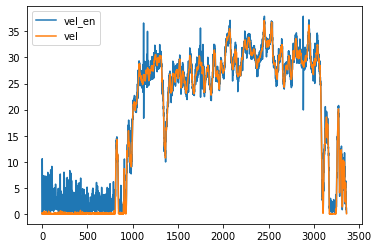

In [32]:
df_temp[["vel_en","vel"]].plot()#概ね一致している

In [33]:
from scipy import signal
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2  
    wp = fp / fn  
    ws = fs / fn  
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  
    b, a = signal.butter(N, Wn, "low")            
    y = signal.filtfilt(b, a, x)                  
    return y  

fp = 1000 
fs = 2000 
gpass = 3 
gstop = 40 
samplerate = 25600
# low path 

df_temp["w_z_f"] = lowpass(df_temp["w_z"], samplerate, fp, fs, gpass, gstop)

In [34]:
# def fx(x,u):
#     #x[e,n,yaw,vel]
#     #u[Angle velocity,acceleration]
#     res = np.zeros(4)
#     res[0] = x[0] + (x[3])*np.cos(x[2])#x
#     res[1] = x[1] + (x[3])*np.sin(x[2])#y
    
#     if x[3] <= 20:
#         th = 360
#     elif x[3] <= 30:
#         th = 40
#     else:
#         th = 10
    
#     if np.rad2deg(u[0]) > th:
#         u[0] = np.deg2rad(th)
#     if np.rad2deg(u[0]) < - th:
#         u[0] = np.deg2rad(- th)
#     res[2] = x[2] + u[0]
#     res[3] = x[3] + u[1]
#     return res

In [35]:
def fx(x,u):
    #x[e,n,yaw]
    #u[velocity、Angle velocity]
    res = np.zeros(3)
    res[0] = x[0] + (u[0])*np.cos(x[2])#x
    res[1] = x[1] + (u[0])*np.sin(x[2])#y
    
    if u[0] <= 20:
        th = 360
    elif u[0] <= 30:
        th = 40
    else:
        th = 10
    
    if np.rad2deg(u[1]) > th:
        u[1] = np.deg2rad(th)
    if np.rad2deg(u[1]) < - th:
        u[1] = np.deg2rad(- th)
    res[2] = x[2] + u[1]
        
    return res

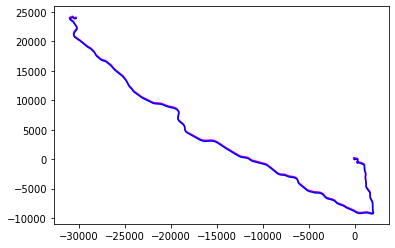

In [36]:
#check fx
df_temp_ = df_temp.reset_index()
us = df_temp_[["vel_en","yaw_doppler_rad_diff"]].to_numpy()
x = df_temp_[["e","n","yaw_doppler_rad"]].loc[0].to_numpy()
s = []
for i, u in enumerate(us):
    s.append(x)
    x = fx(x,u)
    
plt.plot(np.array(s)[:, 0],np.array(s)[:, 1],c = "m")
plt.plot(df_temp_[:].e,df_temp_[:].n,c = "b")

In [37]:
def jacobian_fx(x,u):
    v = u[0]
    gry = u[1]#角速度
    theta = x[2]
    return np.array ([[1, 0, -v*np.sin(theta)],
                      [0, 1, v*np.cos(theta)],
                      [0, 0, 1]
                     ])

In [38]:
def jacobian_fu(x,u):
    v = u[0]
    gry = u[1]#角速度
    theta = x[2]
    return np.array ([[np.cos(theta),0],
                      [np.sin(theta),0],
                      [0, 1]
                     ])

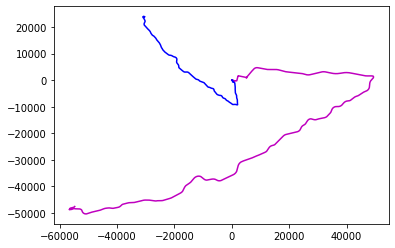

In [39]:
#check jacobian
df_temp_ = df_temp.reset_index()
us = df_temp_[["vel_en","yaw_doppler_rad_diff"]].to_numpy()
x = df_temp_[["e","n","yaw_doppler_rad"]].loc[0].to_numpy()
s = []
for i, u in enumerate(us):
    s.append(x)
    F = jacobian_fx(x,u)
    G = jacobian_fu(x,u)
    x = F @ x + G @ u
    
plt.plot(np.array(s)[:, 0],np.array(s)[:, 1],c = "m")
plt.plot(df_temp_[:].e,df_temp_[:].n,c = "b")
#

In [40]:
# Kalman filter
def Kalman_filter(zs, us):
    # Parameters
    sigma_v = 0.6
    sigma_x = 5 # position SD m
    sigma_mahalanobis = 30.0 # Mahalanobis distance for rejecting innovation
    
    n, dim_x = zs.shape
    Q = sigma_v**2 * np.eye(2)  # Process noise

    H = np.eye(3)  # Measurement function
    R = sigma_x**2 * np.eye(3)  # Measurement noise

    # Initial state and covariance
    x = zs[0, :3].T  # State
    P = sigma_x**2 * np.eye(3)  # State covariance
    I = np.eye(dim_x)

    x_kf = np.zeros([n, dim_x])
    P_kf = np.zeros([n, dim_x, dim_x])

    # Kalman filtering
    for i, (u, z) in enumerate(zip(us, zs)):
        # First step
        if i == 0:
            x_kf[i] = x.T
            P_kf[i] = P
            continue

        # Prediction step
        # add non linear
        
        F = jacobian_fx(x,u)
#         print(F.shape,P.shape)
        G = jacobian_fu(x,u)
        temp1 = (G @ Q)
        temp = (G @ Q) @ G.T
        P = (F @ P) @ F.T + (G @ Q) @ G.T
    
        x = fx(x,u)
        # Check outliers for observation
        d = distance.mahalanobis(z, H @ x, np.linalg.pinv(P))
        
        # Update step
        if d < sigma_mahalanobis:
            y = z.T - H @ x
            S = (H @ P) @ H.T + R
            K = (P @ H.T) @ np.linalg.inv(S)
            x = x + K @ y
            P = (I - (K @ H)) @ P
        else:
            print()
            # If no observation update is available, increase covariance
            P += 10**2*((G @ Q) @ G.T)

        x_kf[i] = x.T
        P_kf[i] = P

    return x_kf, P_kf


# Forward + backward Kalman filter and smoothing
def Kalman_smoothing(en, u):
    n, dim_x = en.shape

    # Forward
    u_f = np.vstack([np.zeros([1, 2]), (u[:-1, :] + u[1:, :])/2])
    x_f, P_f = Kalman_filter(en, u_f)
    # Backward
    u = -np.flipud(u)
    u = np.vstack([np.zeros([1, 2]), (u[:-1, :] + u[1:, :])/2])
    x_b, P_b = Kalman_filter(np.flipud(en), u)

    # Smoothing
    x_fb = np.zeros_like(x_f)
    P_fb = np.zeros_like(P_f)
    for (f, b) in zip(range(n), range(n-1, -1, -1)):
        P_fi = np.linalg.inv(P_f[f])
        P_bi = np.linalg.inv(P_b[b])

        P_fb[f] = np.linalg.inv(P_fi + P_bi)
        x_fb[f] = P_fb[f] @ (P_fi @ x_f[f] + P_bi @ x_b[b])

    return x_fb, x_f, np.flipud(x_b)

In [41]:
df_temp["yaw_doppler_rad_diff"] = df_temp["yaw_doppler_rad_diff"].fillna(0)
en = df_temp[["e","n","yaw_doppler_rad"]].to_numpy()
u = df_temp[["vel","yaw_doppler_rad_diff"]].to_numpy()
x_kf, x_f, _ = Kalman_smoothing(en, u)

In [42]:
# check ekf score(gnss only)
llh_kf = np.array(pm.enu2geodetic(x_f[:, 0], x_f[:, 1], df_temp["u"],lat0,lon0,h0)).T
score_kf = calc_score(llh_kf[:-1, :], llh_gt[:-1, :])
print(f'Score KF         {score_kf:.4f} [m]')
print(f'Score base         {score:.4f} [m]')

Score KF         4.1662 [m]
Score base         4.3134 [m]


note: The use of approximate formulas has reduced accuracy.

In [43]:
temp = df_temp.copy()
temp["LatitudeDegrees"] = llh_kf[:,0]
temp["LongitudeDegrees"] = llh_kf[:,1]
visualize_trafic(temp.reset_index(),["index","vel"],name_ = "vel")

In [44]:
# add imu

In [45]:
en = df_temp[["e","n","yaw_doppler_rad"]].to_numpy()
u = df_temp[["vel","w_z_f"]].to_numpy()
x_kf, x_f, x_b = Kalman_smoothing(en, u)

In [46]:

llh_kf_b = np.array(pm.enu2geodetic(x_kf[:, 0], x_kf[:, 1], df_temp["u"],lat0,lon0,h0)).T
score_kf = calc_score(llh_kf_b[:-1, :], llh_gt[:-1, :])
print(f'Score KF         {score_kf:.4f} [m]')
print(f'Score base         {score:.4f} [m]')

Score KF         6.6562 [m]
Score base         4.3134 [m]


In [47]:
temp = df_temp.copy()
temp["LatitudeDegrees"] = llh_kf_b[:,0]
temp["LongitudeDegrees"] = llh_kf_b[:,1]
visualize_trafic(temp.reset_index(),["index","vel"],name_ = "vel")

In [48]:
llh_kf_f = np.array(pm.enu2geodetic(x_f[:, 0], x_f[:, 1], df_temp["u"],lat0,lon0,h0)).T
score_kf = calc_score(llh_kf_f[:-1, :], llh_gt[:-1, :])
print(f'Score KF         {score_kf:.4f} [m]')
print(f'Score base         {score:.4f} [m]')
temp = df_temp.copy()
temp["LatitudeDegrees"] = llh_kf_f[:,0]
temp["LongitudeDegrees"] = llh_kf_f[:,1]

Score KF         4.5189 [m]
Score base         4.3134 [m]


In [49]:
visualize_trafic(temp.reset_index(),["index","yaw_doppler"],name_ = "yaw_doppler")

In [50]:
llh_kf = np.array(pm.enu2geodetic(x_b[:, 0], x_b[:, 1], df_temp["u"],lat0,lon0,h0)).T
score_kf = calc_score(llh_kf[:-1, :], llh_gt[:-1, :])
print(f'Score KF         {score_kf:.4f} [m]')
print(f'Score base         {score:.4f} [m]')
temp = df_temp.copy()
temp["LatitudeDegrees"] = llh_kf[:,0]
temp["LongitudeDegrees"] = llh_kf[:,1]

Score KF         4.1269 [m]
Score base         4.3134 [m]


In [51]:
visualize_trafic(temp.reset_index(),["index","yaw_doppler"],name_ = "yaw_doppler")

I worked on utilizing the extended Kalman filter and imu, but did not see any improvement in scores.
As I posted in the discussion, in the future I will try to see if I can use high period data to interpolate between GNSS